In [1]:
# Import graphics related libraries
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('whitegrid')


from IPython.display import Image
from IPython import display
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

# other libraries
import numpy as np
import scipy as sp
import pandas as pd
import simplejson
import sys
import requests
import sqlite3
from collections import Counter
import heapq

/Users/yinagu/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# NLP of tweet
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import MiniBatchKMeans
import string

In [3]:
# connect database
conn = sqlite3.connect('/Users/yinagu/pokemon.sqlite')
cur = conn.cursor()

cur.execute('''
SELECT content FROM hashtags WHERE content IS NOT NULL''')
counter_word = Counter()
counter_hashtag = Counter()

def contain_any(word, char_set):
    return 1 in [char in word for char in char_set]

for row in cur:
    tweet = str(row).lower().split()
    for word in tweet:
        if word not in stopwords.words('english'):
            if not contain_any(word, string.punctuation):
                counter_word[word]+=1
            elif contain_any(word, '#'):
                counter_hashtag[word]+=1
                
df_word = pd.DataFrame(heapq.nlargest(100, counter_word.items(), key=lambda x:x[1]), 
                  columns=['word','count'])
df_hashtag = pd.DataFrame(heapq.nlargest(100, counter_hashtag.items(), key=lambda x:x[1]), 
                          columns=['hashtag','count'])

In [4]:
df_word.head(10)

,word,count
0,go,13141
1,catch,12412
2,pokemon,12282
3,new,9288
4,playing,9042
5,like,8048
6,people,7410
7,get,6288
8,think,5210
9,look,5184


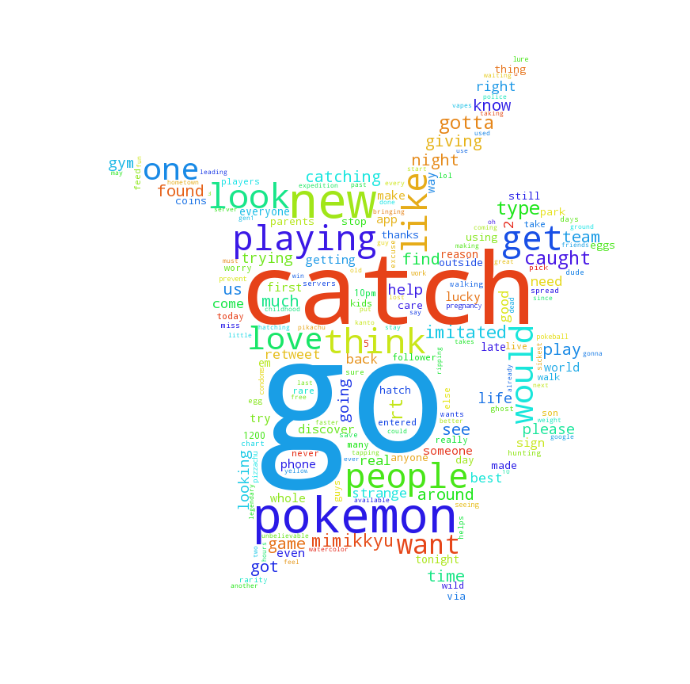

In [50]:
# wordcloud for most popular words
pokemon_mask = sp.misc.imread('pikachu.png', flatten=True)
wordcloud = WordCloud(background_color='white', mask=pokemon_mask, 
                      width=400, height=600).fit_words(counter_word.items())
plt.axis("off")
plt.imshow(wordcloud)
#plt.show()
plt.savefig('wcld_pokemon.png', dpi=400)

In [10]:
# Remove any hashtag contains 'pokemon'
df_hashtag = pd.DataFrame(heapq.nlargest(100, counter_hashtag.items(), key=lambda x:x[1]), 
                          columns=['hashtag','count'])
df_hashtag = df_hashtag.loc[['mon' not in s for s in df_hashtag.hashtag]]

In [11]:
list_hashtag=list()
for h,c in zip(df_hashtag['hashtag'], df_hashtag['count'].tolist()):
    list_hashtag.append((h,c))

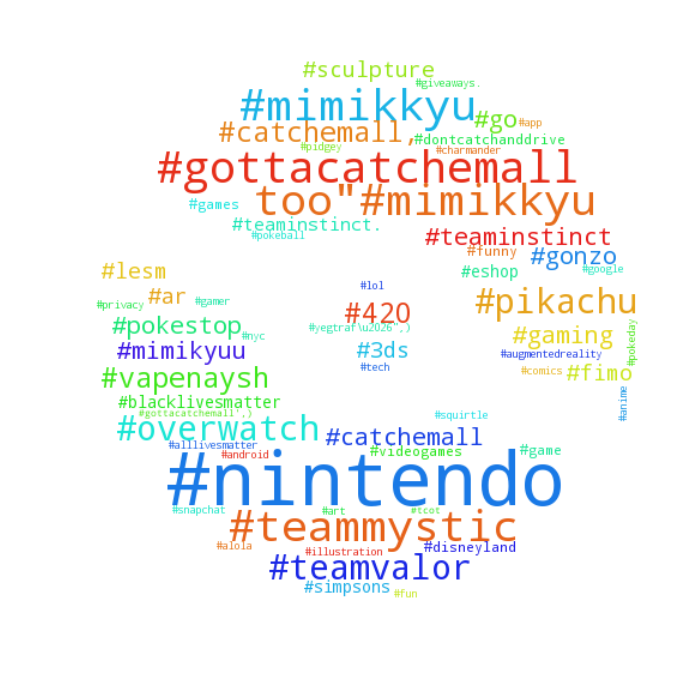

In [53]:
# wordcloud for the top 50 hashtags related to #PokeMonGo
pokemon_mask = sp.misc.imread('pokemon.png', flatten=True)
wordcloud = WordCloud(background_color='white', mask=pokemon_mask, 
                      width=300, height=300).fit_words(list_hashtag)
plt.axis("off")
plt.imshow(wordcloud)
plt.savefig('wcld_pokemon2.png', dpi=400)

In [19]:
# Percentage of #overwatch among all # 
a = float(counter_hashtag['#overwatch'])
b = counter_hashtag['#pokemon']+counter_hashtag['#pokemongo']
#b = sum(counter_hashtag.values())
print a/b *100

0.726128524749


In [42]:
## K-means topic modeling
#connect to database
conn = sqlite3.connect('/Users/yinagu/pokemon.sqlite')
cur = conn.cursor()
# Select columns from DB
cur.execute('''
SELECT content FROM hashtags WHERE content IS NOT NULL''')
list_tweet=list()
for row in cur:
    tw = str(row).lower()
    list_tweet.append(tw[3:-3])
df_tweet = pd.DataFrame(list_tweet, columns=['tweet'])

In [44]:
df_tweet['tweet'][0]

'this pidgey must be siiiiick #pokemongo #pokemon https://t.co/hl4zj8z7lu'

In [86]:
# Pre-process the text 
import re
def tweet_process(mess):
    '''Take a string and:
    1. remove all punctuation, and 'http'
    2. remove stopwords, 
    3. return a list of cleaned text'''
    
    # seperate #A#B to A, B
    mess = mess.replace('#',' ')
    # remove annoying unicode i.e. '\u2026'
    mess = mess.decode('unicode_escape').encode('ascii','ignore')
    # remove @string
    mess = re.sub('@[^ ]*', ' ', mess)
    mess = re.sub('\x[^ ]*', ' ', mess)
    nopunc = [char for char in mess if (char not in string.punctuation)]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if (
            word.lower() not in stopwords.words('english') 
            and 'http' not in word.lower()
        and 'u000' not in word.lower())]

ValueError: invalid \x escape

In [68]:
df_tweet['tweet'][30]

"rt @causeyclayton: so i wonder how long it'll be before people hire #uber drivers to drive them around to catch #pokemon? #pokeuber"

In [69]:
tweet_process(df_tweet['tweet'][30])

['rt',
 'wonder',
 'long',
 'itll',
 'people',
 'hire',
 'uber',
 'drivers',
 'drive',
 'around',
 'catch',
 'pokemon',
 'pokeuber']

In [90]:
# Create text process pipeline

pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer = tweet_process)),
        ('tfidf', TfidfTransformer()),
        ('mbkmeans', MiniBatchKMeans(n_clusters=3, batch_size=1000))
    ])

pipeline.fit(df_tweet.tweet)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function tweet_process at 0x1193a0578>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=No...sters=3,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0))])

In [92]:
def make_wordcloud(wordcounts):
    '''Subplot wordclouds by topics'''
    wdclds = [WordCloud(background_color='white').fit_words(counts) for counts in wordcounts]
    fig, axes = plt.subplots(3,1)
    for k, (ax, wdcld) in enumerate(zip(axes.flatten(), wdclds)):
        ax.axis("off")
        ax.imshow(wdcld)
        ax.set_title('Topic %d' %(int(k)+1))
    display.display(fig)
    plt.savefig('wcld_topics.png', dpi=400)
    fig.clear()

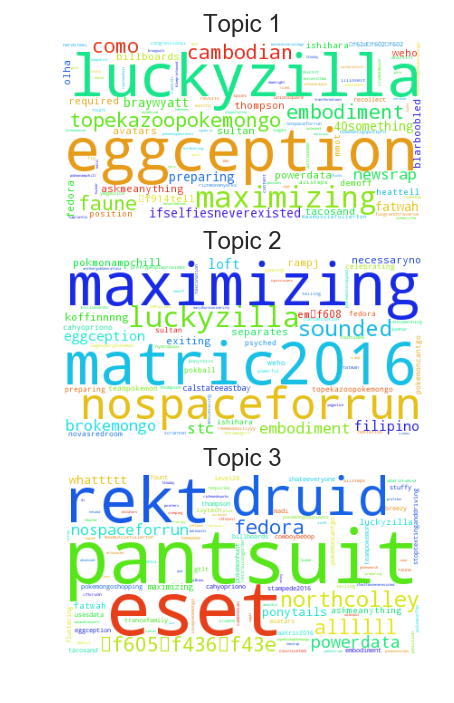

In [94]:
words = pipeline.named_steps['bow'].vocabulary_.keys()
wordcounts = [heapq.nlargest(100, zip(words, pipeline.named_steps['mbkmeans'].cluster_centers_[i]), key=lambda x:x[1]) 
              for i in xrange(pipeline.named_steps['mbkmeans'].n_clusters)]
make_wordcloud(wordcounts)


In [85]:
wordcounts[0:3]

[[('pantsuit', 0.32312170283078867),
  ('eset', 0.23367780930937751),
  ('rekt', 0.23334469107238839),
  ('druid', 0.23068423939780694),
  ('northcolley', 0.21710314823236915),
  ('\x01f605\x01f436\x01f43e', 0.21472815365775569),
  ('allllll', 0.21291926744352155),
  ('powerdata', 0.19151303832560607),
  ('fedora', 0.18703936116551734),
  ('nospaceforrun', 0.17254002103543883),
  ('ponytails', 0.13245889206869124),
  ('whattttt', 0.12827785091289265),
  ('askmeanything', 0.12384046618735386),
  ('luckyzilla', 0.1123809009306283),
  ('fatwah', 0.11155610921013534),
  ('maximizing', 0.04988065640409315),
  ('stampede2016', 0.0043807042686901162),
  ('breezy', 0.0021903521343450581),
  ('usesdata', 0.002189675601805208),
  ('trancefamily', 0.0021890005071676945),
  ('cowboybebop', 0.002183650790689455),
  ('ivytech', 0.002174500267545018),
  ('gtlt', 0.0019556257948824926),
  ('stuffy', 0.0018802519019044098),
  ('blarboobled', 0.001708322702282223),
  ('battlea', 0.0016905598243937333),


In [54]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'